# Evaluation Metrics

In [1]:
import pandas as pd
import numpy as np
import copy
import os
from scipy.stats import friedmanchisquare
from scipy.stats import chi2
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import itertools

# change to your local path to project below
project_path = '/home/cerebriu/Documents/KDS_Statistics_GroupProject'
# TO DO:
# - Fix W

In [2]:
featureranks_basepath = os.path.join(project_path, 'data')
all_ranks_all_methods_long = pd.DataFrame()

# Put all ranks into one csv
for file in os.listdir(featureranks_basepath):
    if file.endswith('.csv') and file != 'featureranks_ALLMETHODS.csv':
        df = pd.read_csv(os.path.join(featureranks_basepath, file), sep=";")
        all_ranks_all_methods_long = pd.concat([all_ranks_all_methods_long, df], axis=0)

# Save all ranks together
all_ranks_all_methods_long.to_csv(os.path.join(project_path, 'data', 'featureranks_ALLMETHODS.csv'), sep=";", index=False)
all_ranks_all_methods_long = all_ranks_all_methods_long.query('method != "Lasso_regression"') # temporarily take out these methods


In [3]:
all_ranks_all_methods_long.query('method != "Lasso_regression"').groupby(['method', 'dataset'])['feature_name'].count()

method             dataset             
CART               Airbnb_price            18
                   Bike_sharing            12
                   USA_houseprices_2014    13
                   austin_housing          27
                   cars                    34
Linear_regression  Airbnb_price            18
                   Bike_sharing            12
                   USA_houseprices_2014    13
                   austin_housing          27
                   cars                    34
Random_forest      Airbnb_price            18
                   Bike_sharing            12
                   USA_houseprices_2014    13
                   austin_housing          27
                   cars                    34
Ridge_regression   Airbnb_price            18
                   Bike_sharing            12
                   USA_houseprices_2014    13
                   austin_housing          27
                   cars                    34
elastic_net        Airbnb_price         

## Kendall's W

### Using friedmanchisquare
(DOES NOT seem to work and requires manually putting all columns)

In [4]:

# spRes = friedmanchisquare(data_kendall['PCA'].to_numpy(), data_kendall['RandomForest'].to_numpy(), data_kendall['linear_regression'].to_numpy())
# spRes = friedmanchisquare(*[data_kendall[column] for column in data_kendall.columns])
# friedmanchisquare()
# selData()
# n = data_kendall.shape[0]
# k = data_kendall.shape[1]
# Q = spRes[0]
# print(f"n: {n},k: {k}, Q: {Q}")

In [5]:
# W = Q / (n*(k-1))
# print(f"W: {W}")

### Using direct formula

In [60]:
def calculate_kendallW(data_kendall, form= 'lower'):
    '''_summary_

    Args:
        data_kendall (pd.dataframe): Datafrem containing as columns the feature
        selection methods and as values ranks to each feature in the same order.

    Returns:
        W: Kendall's W coefficient
    '''
    n = data_kendall.shape[0] # number of features/objects
    m = data_kendall.shape[1] # numbe of raters/methods

    # Sum of each item ranks
    R_i = data_kendall.sum(axis=1, numeric_only=True).to_numpy()
    # Mean of ranking sums
    Rbar = R_i.mean()
    # Sum of squared deviations from the mean
    S = np.sum([(r_i - Rbar)**2 for r_i in R_i])
    SSR = np.sum([(r_i)**2 for r_i in R_i])

    # Compute correction factor T
    T = 0
    for method in data_kendall.columns:
        grouped_ranks = [list(j)  for i, j in itertools.groupby(data_kendall[method])]
        grouped_tied_ranks = [group for group in grouped_ranks if len(group) > 1]
        g_i = len(grouped_tied_ranks)
        T_j = 0
        if g_i == 0:
            continue
        else:
            for group in  grouped_tied_ranks:
                t_i = len(group)
                T_j += (t_i**3 - t_i)
        
        T += T_j

    # Compute W, upper form    
    W_upper = (12*S) / ((m**2)*(n**3 - n))

    # Compute W, upper form, corrected for ties
    W_upper_corrected = (12*S) / ((m**2)*(n**3 - n) - m*T)

    # Compute W, lower form
    W_lower = (12*SSR - (3*(m**2)*n*(n + 1)**2))/ \
        ((m**2)*(n**3 - n))
    
    # Compute W, lower form, corrected for ties
    W_lower_corrected = (12*SSR - (3*(m**2)*n*(n + 1)**2))/ \
        ((m**2)*(n**3 - n) -m*T)

    if form == 'upper':
        W, W_corrected = W_upper, W_upper_corrected
    elif form == 'lower':
        W, W_corrected = W_lower, W_lower_corrected

    return round(W, ndigits=3), round(W_corrected, ndigits=3)

## Top–k overlap

In [61]:
def calculate_topkoverlap(datatopk, k):

    data_all = datatopk.copy(deep=True)

    n = len(data_all)

    assert len(data_all) >= k, f"Maximum value for k is {n}, which is total number of features"

    methods = data_all.columns.to_list()
    data_all['feature_id'] = data_all.index

    all_toplists = []

    for method in methods:
        data_temp = data_all.filter(items=['feature_id', method]) \
            .sort_values(method).head(k)['feature_id'].to_list()
        all_toplists.append(data_temp)
    union_lists= np.unique(all_toplists)
    intersection_lists = set.intersection(*map(set, all_toplists))

    topk_overlap = len(intersection_lists)/len(union_lists)
        
    return topk_overlap


In [62]:
all_ranks_all_methods_long.query('dataset == "USA_houseprices_2014"').pivot( index=['dataset', 'feature_name'], columns=['method'], 
        values=['feature_rank']).reset_index()

dataset               feature_name feature_rank  \
method                                                          CART   
0       USA_houseprices_2014                  bathrooms          4.0   
1       USA_houseprices_2014                   bedrooms         11.0   
2       USA_houseprices_2014                       city          6.0   
3       USA_houseprices_2014                  condition          1.0   
4       USA_houseprices_2014                     floors         12.0   
5       USA_houseprices_2014              have_basement         13.0   
6       USA_houseprices_2014              sqft_basement          9.5   
7       USA_houseprices_2014                sqft_living          2.0   
8       USA_houseprices_2014                   sqft_lot          5.0   
9       USA_houseprices_2014                   statezip          3.0   
10      USA_houseprices_2014                       view          9.5   
11      USA_houseprices_2014                 waterfront          7.5   
12      USA_houseprices_2014  year_since_1st_renovation          7.5   

                                                                     
method Linear_regression Random_forest Ridge_regression elastic_net  
0                    9.0           5.0              2.0         9.0  
1                    3.0           9.0             12.0         3.0  
2                    8.0           4.0              7.5         8.0  
3                    7.0          11.0              6.0         7.0  
4                   11.5          12.0              7.5        11.0  
5                   11.5          13.0             13.0        13.0  
6                    6.0           6.0              5.0         6.0  
7                    1.0           1.0              1.0         1.0  
8                    2.0           3.0              9.0         2.0  
9                   11.5           2.0             10.0        10.0  
10                   5.0           8.0              3.0         5.0  
11                   4.0          10.0              4.0         4.0  
12                  11.5           7.0             11.0        12.0

## Hypothesis testing for all datasets

In [63]:
def get_metrics(all_ranks_all_methods_long, dataset_name, alpha = 0.05, W_type='upper', W_corrected=True, verbose=True): 

    # Transform to long for better manipulation
    data_ranks_wide = all_ranks_all_methods_long.query('dataset == @dataset_name').pivot( index=['dataset', 'feature_name'], columns=['method'], 
        values=['feature_rank']).reset_index()

    # --------------------- Calculate Kendall's W ------------------------------
    data_kendall = data_ranks_wide['feature_rank'].astype(int)
    W, W_tiecorrected = calculate_kendallW(data_kendall, form=W_type)

    n = data_kendall.shape[0] # number of objects/(features)
    m = data_kendall.shape[1] # number of raters(methods)

    if not W_corrected:
        W_used = W
    elif W_corrected:
        W_used = W_tiecorrected
    
    if W_used <= 0.3:
        level_agreement = 'weak'
    elif 0.3 < W_used<= 0.6:
        level_agreement = 'moderate'
    elif W_used > 0.6:
        level_agreement = 'strong'


    # -------------------- Perform test of significance ------------------------
    # theory:  When n ≥ 5 or m > 15, m(n–1)W ~ χ2 (n–1).
    degrees_of_freedom = n - 1
    chisquared_alpha = round(chi2.ppf(q = alpha, df = degrees_of_freedom), ndigits=2)
    
    
    chisquared_statistic = round(m *(n-1) * W_used, ndigits=2)
    # Calculate spearmans mean rank correlation coefficient
    r_spearman_mean = round((m * W_used - 1)/(m - 1), ndigits=5)

    test_passed = chisquared_statistic >= chisquared_alpha

    pvalue = round(chi2.sf(chisquared_statistic , degrees_of_freedom), ndigits=4)

    test_metrics = {
        'W': W_used,
        'chisquared_statistic':chisquared_statistic,
        'chisquared_alpha': chisquared_alpha,
        'test_passed':test_passed, 
        'p-value': pvalue,
        'level_agreement':level_agreement, 
        'degrees_of_freedom':degrees_of_freedom,
        'alpha':alpha,
        'n': n,
        'm': m,
        'r_spearman_mean': r_spearman_mean
     }    

    # ------------------------ Calculate k-overlaps ----------------------------
    k_overlaps = {}
    for i in range(1, n+1):
        k_overlaps[i] = calculate_topkoverlap(data_kendall, k=i)

    if verbose:
        # Print results
        print(f"RESULTS FOR DATASET '{dataset_name}'")
        print(f"There are {n} features and {m} raters")
        print(f"Kendall's W ({W_type}): {W_used}")
        print(f"W is corrected for ties: {W_corrected}")
        print(f"Top-5 overlap: {k_overlaps[5]}")
        print(f"Top-10 overlap: {k_overlaps[10]}")
        print(f"Statistic value(alpha={alpha}): {chisquared_statistic}")
        print(f"Chi2 (alpha={alpha}, {degrees_of_freedom} dof): {chisquared_alpha}") # Tabled value
        if test_passed:
            print("We reject null hypothesis and conclude that H1: W ≠ 0.")
        else:
            print("We cannot reject null hypothesis H0: W = 0")
        
        print('-------------------------------------------------------------------')


    return k_overlaps, test_metrics

In [64]:
results_df = pd.DataFrame()
koverlaps_dict = {}

for dataset_name in all_ranks_all_methods_long['dataset'].unique():

    # Perform hypothesis test - normal W
    k_overlaps, test_metrics = get_metrics(all_ranks_all_methods_long, dataset_name, W_type='upper', W_corrected = False, verbose=False)
    # Add all results to list

    # Perform hypothesis test - corrected W
    k_overlaps, test_metrics_c = get_metrics(all_ranks_all_methods_long, dataset_name, W_type='upper', W_corrected = True, verbose=True)

    results_df = pd.concat([results_df, 
                        pd.DataFrame({'dataset_name': dataset_name} | test_metrics | {f"{k}_c":v for k,v in test_metrics_c.items()}, index=[0])], 
                        axis= 0 )
    koverlaps_dict[dataset_name] = k_overlaps


RESULTS FOR DATASET 'USA_houseprices_2014'
There are 13 features and 5 raters
Kendall's W (upper): 0.537
W is corrected for ties: True
Top-5 overlap: 0.1
Top-10 overlap: 0.5833333333333334
Statistic value(alpha=0.05): 32.22
Chi2 (alpha=0.05, 12 dof): 5.23
We reject null hypothesis and conclude that H1: W ≠ 0.
-------------------------------------------------------------------
RESULTS FOR DATASET 'Bike_sharing'
There are 12 features and 5 raters
Kendall's W (upper): 0.727
W is corrected for ties: True
Top-5 overlap: 0.6666666666666666
Top-10 overlap: 0.6666666666666666
Statistic value(alpha=0.05): 39.98
Chi2 (alpha=0.05, 11 dof): 4.57
We reject null hypothesis and conclude that H1: W ≠ 0.
-------------------------------------------------------------------
RESULTS FOR DATASET 'Airbnb_price'
There are 18 features and 5 raters
Kendall's W (upper): 0.537
W is corrected for ties: True
Top-5 overlap: 0.2222222222222222
Top-10 overlap: 0.3333333333333333
Statistic value(alpha=0.05): 45.64
Chi2

In [65]:
results_df

,dataset_name,W,chisquared_statistic,chisquared_alpha,test_passed,p-value,level_agreement,degrees_of_freedom,alpha,n,...,chisquared_statistic_c,chisquared_alpha_c,test_passed_c,p-value_c,level_agreement_c,degrees_of_freedom_c,alpha_c,n_c,m_c,r_spearman_mean_c
0,USA_houseprices_2014,0.537,32.22,5.23,True,0.0013,moderate,12,0.05,13,...,32.22,5.23,True,0.0013,moderate,12,0.05,13,5,0.42125
0,Bike_sharing,0.727,39.98,4.57,True,0.0000,strong,11,0.05,12,...,39.98,4.57,True,0.0000,strong,11,0.05,12,5,0.65875
0,Airbnb_price,0.536,45.56,8.67,True,0.0002,moderate,17,0.05,18,...,45.64,8.67,True,0.0002,moderate,17,0.05,18,5,0.42125
0,austin_housing,0.654,85.02,15.38,True,0.0000,strong,26,0.05,27,...,85.28,15.38,True,0.0000,strong,26,0.05,27,5,0.57000
0,cars,0.659,108.74,20.87,True,0.0000,strong,33,0.05,34,...,108.74,20.87,True,0.0000,strong,33,0.05,34,5,0.57375


## Data for Lattex

### Hypothesis test

In [66]:
print(results_df[['dataset_name', 'n', 'm', 'W', 'level_agreement', 'W_c', 'level_agreement_c']].to_latex(index=False))

\begin{tabular}{lrrrlrl}
\toprule
        dataset\_name &  n &  m &     W & level\_agreement &   W\_c & level\_agreement\_c \\
\midrule
USA\_houseprices\_2014 & 13 &  5 & 0.537 &        moderate & 0.537 &          moderate \\
        Bike\_sharing & 12 &  5 & 0.727 &          strong & 0.727 &            strong \\
        Airbnb\_price & 18 &  5 & 0.536 &        moderate & 0.537 &          moderate \\
      austin\_housing & 27 &  5 & 0.654 &          strong & 0.656 &            strong \\
                cars & 34 &  5 & 0.659 &          strong & 0.659 &            strong \\
\bottomrule
\end{tabular}



/tmp/ipykernel_32147/3774768375.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_df[['dataset_name', 'n', 'm', 'W', 'level_agreement', 'W_c', 'level_agreement_c']].to_latex(index=False))


In [48]:
print(results_df[['dataset_name', 'degrees_of_freedom_c', 'chisquared_statistic_c', 'chisquared_alpha_c', 'test_passed_c', 'p-value_c']].to_latex(index=False))

\begin{tabular}{lrrrlr}
\toprule
        dataset\_name &  degrees\_of\_freedom\_c &  chisquared\_statistic\_c &  chisquared\_alpha\_c &  test\_passed\_c &  p-value\_c \\
\midrule
USA\_houseprices\_2014 &                    12 &                   32.22 &                5.23 &           True &     0.0013 \\
        Bike\_sharing &                    11 &                   39.98 &                4.57 &           True &     0.0000 \\
        Airbnb\_price &                    17 &                   45.64 &                8.67 &           True &     0.0002 \\
      austin\_housing &                    26 &                   85.28 &               15.38 &           True &     0.0000 \\
                cars &                    33 &                  108.74 &               20.87 &           True &     0.0000 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_32147/3533909725.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(results_df[['dataset_name', 'degrees_of_freedom_c', 'chisquared_statistic_c', 'chisquared_alpha_c', 'test_passed_c', 'p-value_c']].to_latex(index=False))


### K-overlaps

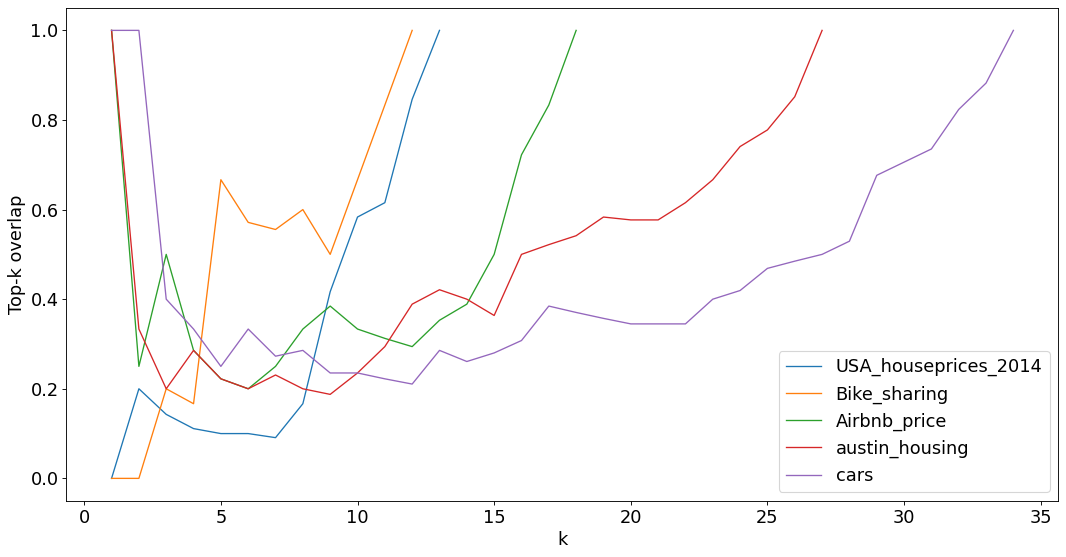

In [52]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['lines.linewidth'] = 1.2

fig, ax = plt.subplots(figsize=(16, 8), dpi=80)

for i, dataset_name in enumerate(all_ranks_all_methods_long['dataset'].unique()):

    data = koverlaps_dict[dataset_name]
    # Ploting: k-overlaps
    ax.plot(data.keys(), data.values(), label=dataset_name)
    ax.set_xlabel('k')
    ax.set_ylabel('Top-k overlap')

ax.legend()
fig.savefig(os.path.join(project_path, 'img',"Topk_overlaps_alldataset.png"), dpi=200, bbox_inches='tight' )



In [53]:
top5_Data = pd.DataFrame()

for i, dataset_name in enumerate(all_ranks_all_methods_long['dataset'].unique()):

    top5_Data = pd.concat([top5_Data, pd.DataFrame( {'dataset_name': dataset_name }| {k:round(v, ndigits=2) for k,v in koverlaps_dict[dataset_name].items() if int(k) < 6 }, index=[0])], axis=0)


In [54]:
print(top5_Data.to_latex(index=False))

\begin{tabular}{lrrrrr}
\toprule
        dataset\_name &   1 &    2 &    3 &    4 &    5 \\
\midrule
USA\_houseprices\_2014 & 0.0 & 0.20 & 0.14 & 0.11 & 0.10 \\
        Bike\_sharing & 0.0 & 0.00 & 0.20 & 0.17 & 0.67 \\
        Airbnb\_price & 1.0 & 0.25 & 0.50 & 0.29 & 0.22 \\
      austin\_housing & 1.0 & 0.33 & 0.20 & 0.29 & 0.22 \\
                cars & 1.0 & 1.00 & 0.40 & 0.33 & 0.25 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_32147/216492194.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(top5_Data.to_latex(index=False))
